In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import leidenalg as la
import igraph as ig
import sys
import glob
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pg = "../data/07-clustered-graphs/alpha0.3_k20_res0.006.graphml"
G = nx.read_graphml(pg)
pdf = "../data/06-clustered-df/alpha0.3_k20_res0.006.pkl"
df = pd.read_pickle(pdf)

pcd = "../output/tables/cluster-explorer/FinalSelect/SingleSolExplorer_alpha0.3_k20_res0.006.xlsx"
# first sheet is the cluster details
cluster_details = pd.read_excel(pcd, sheet_name=0)

In [4]:
import networkx as nx

Gpajek = G.copy()

# Remove all attributes except 'eid' from each node
for node, data in Gpajek.nodes(data=True):
    keys_to_remove = [k for k in data if k != "eid"]  # Collect keys to remove
    for k in keys_to_remove:
        data.pop(k, None)  # Remove the key

# Now, convert all remaining node attributes to strings
for node, data in Gpajek.nodes(data=True):
    for k, v in data.items():
        data[k] = str(v)  # Convert attribute to string

# Gpajek is now modified with only 'eid' attributes retained and converted to string
# You can now save Gpajek to the Pajek format
nx.write_pajek(Gpajek, "../data/07-clustered-graphs/alpha0.3_k20_res0.006.net")

In [66]:
# create edgelist df with eid, cluster, and weight
edf = pd.DataFrame(G.edges(data=True))
# rename columns
edf.columns = ["source", "target", "weight"]
edf["weight"] = edf["weight"].apply(lambda x: x["weight"])

edf.to_csv(
    "../data/07-clustered-graphs/edgelist_alpha0.3_k20_res0.006.csv", index=False
)

In [90]:
# create node list with cluster and weight
ndf = pd.DataFrame(G.nodes(data=True))
ndf = ndf.rename(columns={0: "node", 1: "data"})

for key in ndf["data"].values[0].keys():
    ndf[key] = ndf["data"].apply(lambda x: x[key] if key in x.keys() else None)

ndf = ndf.drop(columns=["data"])
# cluster and year to integer
ndf["cluster"] = ndf["cluster"].apply(lambda x: int(x))
ndf["year"] = ndf["year"].apply(lambda x: int(x))
ndf.to_csv(
    "../data/07-clustered-graphs/nodelist_alpha0.3_k20_res0.006.csv", index=False
)
ndf.head()

node                                 doi unique_auth_year  year  \
0   n0        10.1016/0091-3057(82)90040-5     Aagaard_2009  1982   
1   n1        10.1016/0361-9230(82)90039-9   Aagaard_2009_2  1982   
2   n2  10.1111/j.1600-0773.1982.tb00959.x     Aagaard_2018  1982   
3   n3                                None     Aakjaer_2021  1982   
4   n4        10.1016/0028-3908(82)90149-6     Aakjaer_2022  1982   

                                               title                eid id  \
0  Forebrain serotonin and avoidance learning: Be...  2-s2.0-0019989147  0   
1  Serotonergic innervation of the lateral hypoth...  2-s2.0-0020049962  1   
2  Studies on Acute Toxicity and Drug Levels of C...  2-s2.0-0020047901  2   
3  Characterization of serotonin uptake in cultur...  2-s2.0-0020044327  3   
4         Ketamine inhibits serotonin uptake in vivo  2-s2.0-0020031255  4   

   cluster  cluster_ev_centrality  
0      126               0.480903  
1        3               0.144346  
2       47               0.073681  
3       97               0.029359  
4       27               0.014249

In [145]:
mins = ndf.groupby("cluster")["cluster_ev_centrality"].min()
maxs = ndf.groupby("cluster")["cluster_ev_centrality"].max()
means = ndf.groupby("cluster")["cluster_ev_centrality"].mean()
clusters = ndf["cluster"].unique()

# create a df with the cluster details
cluster_centralities = pd.DataFrame(
    {"min": mins, "max": maxs, "mean": means}
).reset_index()

cluster_centralities.sort_values("min", ascending=False)

cluster       min  max      mean
188      188  0.311975  1.0  0.669622
179      179  0.152497  1.0  0.677538
177      177  0.152208  1.0  0.621909
172      172  0.143525  1.0  0.549977
189      189  0.142377  1.0  0.542199
..       ...       ...  ...       ...
113      113  0.000743  1.0  0.271557
167      167  0.000543  1.0  0.422787
141      141  0.000478  1.0  0.363897
108      108  0.000437  1.0  0.231008
105      105  0.000060  1.0  0.209404

[190 rows x 4 columns]

In [119]:
import math
import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle

from itertools import chain

cvsopts = dict(plot_height=400, plot_width=400)

In [109]:
np.random.seed(1)
cats, n, m = 4, 80, 1000

cnodes = pd.concat(
    [
        pd.DataFrame.from_records(
            [("node" + str(i + 100 * c), "c" + str(c)) for i in range(n)],
            columns=["name", "cat"],
        )
        for c in range(cats)
    ],
    ignore_index=True,
)
cnodes.cat = cnodes.cat.astype("category")

cedges = pd.concat(
    [
        pd.DataFrame(
            np.random.randint(n * c, n * (c + 1), size=(m, 2)),
            columns=["source", "target"],
        )
        for c in range(cats)
    ],
    ignore_index=True,
)

In [111]:
cnodes

name cat
0      node0  c0
1      node1  c0
2      node2  c0
3      node3  c0
4      node4  c0
..       ...  ..
315  node375  c3
316  node376  c3
317  node377  c3
318  node378  c3
319  node379  c3

[320 rows x 2 columns]

In [110]:
cedges

source  target
0         37      12
1         72       9
2         75       5
3         79      64
4         16       1
...      ...     ...
3995     264     307
3996     292     251
3997     256     309
3998     263     279
3999     277     274

[4000 rows x 2 columns]

In [115]:
rd = random_layout(cnodes, cedges)
fd = forceatlas2_layout(cnodes, cedges)

In [124]:
def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, "x", "y", agg=ds.count()), name=name)


def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)

    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)


def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator = None if cat is None else ds.count_cat(cat)
    agg = canvas.points(nodes, "x", "y", aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

In [133]:
%time rd_d = graphplot(rd, connect_edges(rd,cedges), "Random layout",          cat="cat")
%time fd_d = graphplot(fd, connect_edges(fd,cedges), "Force-directed",         cat="cat")
# %time rd_b = graphplot(rd, hammer_bundle(rd,cedges), "Random layout, bundled", cat="cat")
# %time fd_b = graphplot(fd, hammer_bundle(fd,cedges), "Force-directed, bundled",cat="cat")

# tf.Images(rd_d, fd_d, rd_b, fd_b)

CPU times: user 86 ms, sys: 12.8 ms, total: 98.8 ms
Wall time: 103 ms
CPU times: user 76.7 ms, sys: 8.76 ms, total: 85.5 ms
Wall time: 87.5 ms



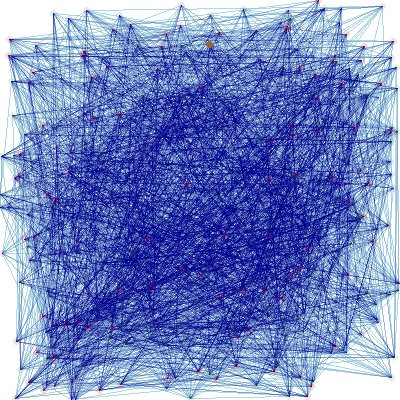
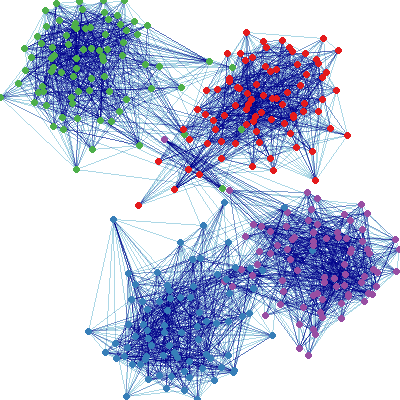

In [134]:
tf.Images(rd_d, fd_d)

# VISUALS


In [57]:
def process_given_labels(summary_df, words_to_remove, n_words=5):
    cols = [col for col in summary_df.columns if col.startswith("Word_")]
    cols = cols[:n_words]
    summary_df["Given Label"] = summary_df[cols].apply(
        lambda row: "; ".join(list(set(row.values))), axis=1
    )
    # add cluster number to the given label
    summary_df["Given Label"] = summary_df[["Cluster", "Given Label"]].apply(
        lambda row: f"{str(row['Cluster'])}: {row['Given Label']}", axis=1
    )
    givenlabel = []
    for label in summary_df["Given Label"]:
        label = [word for word in label[:10] if word not in words_to_remove]
        givenlabel.append(label)
        # print(label)
    # summary_df["Given Label"] = givenlabel

    return summary_df


words_to_remove = [
    "depression",
    "fluoxetine",
    "effects",
    "effect",
    "escitalopram",
    "paroxetine",
    "fluvoxamine",
    "citalopram",
]

summary_df = process_given_labels(cluster_details, words_to_remove, n_words=10)
cluster_label_dict = dict(zip(summary_df["Cluster"], summary_df["Given Label"]))

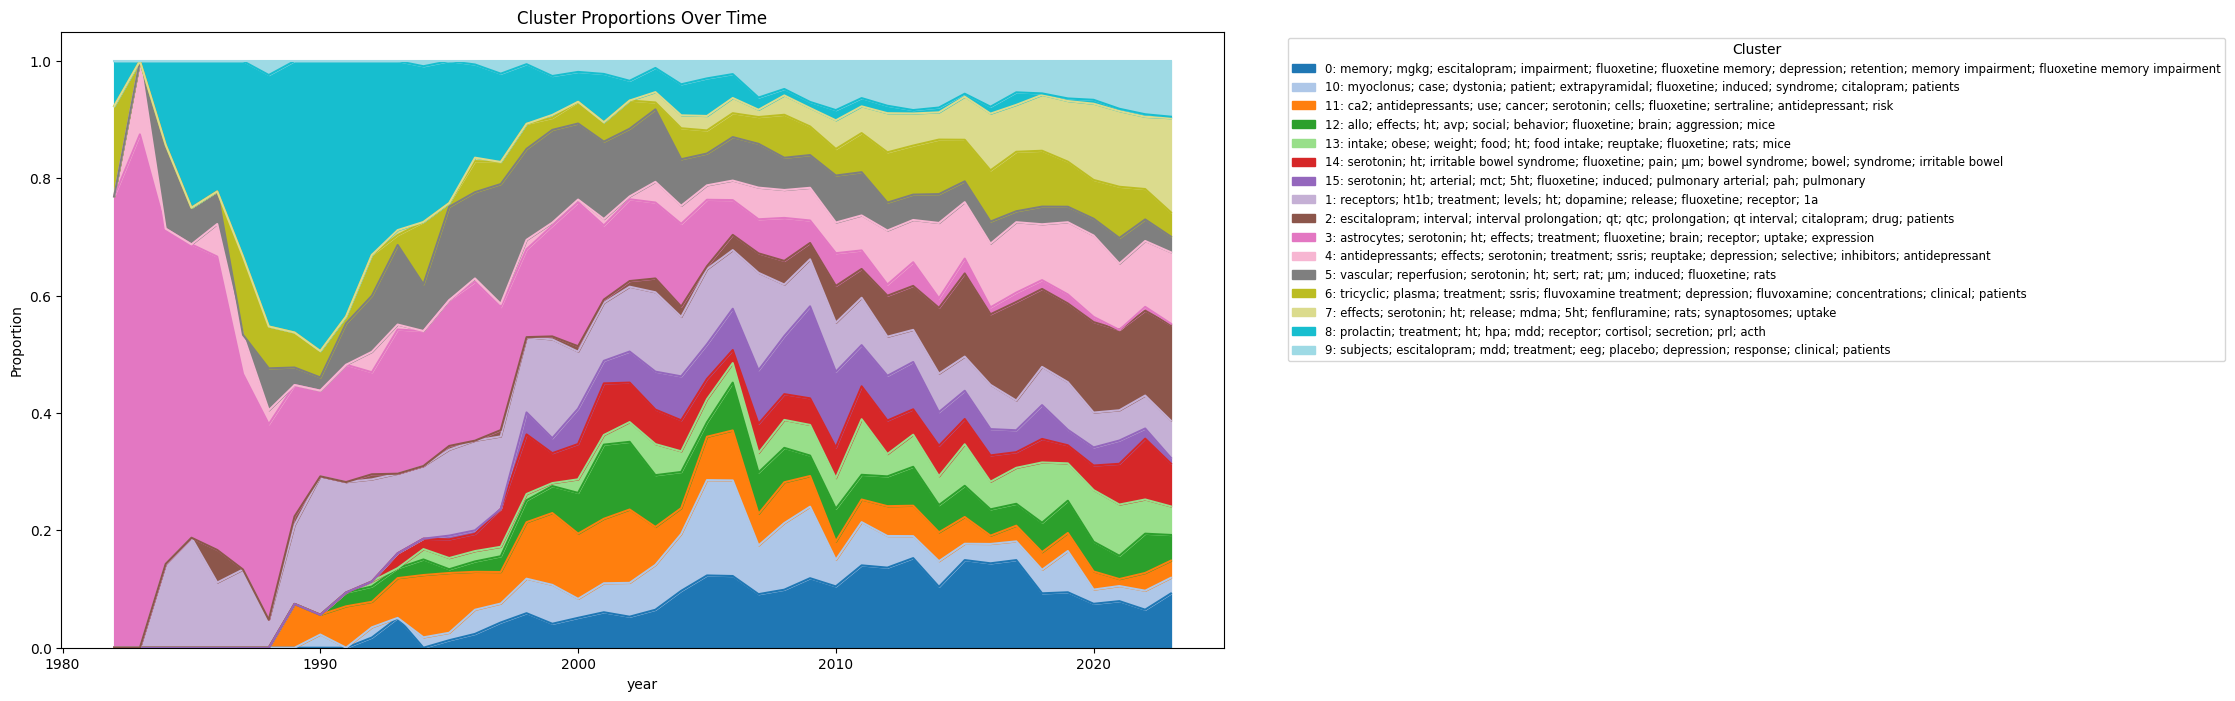

In [174]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_cluster_proportions(
    df,
    year_col,
    cluster_col,
    cluster_range=[0, 10],
    figsize=(10, 6),
    cluster_label_dict=None,
    return_df=False,
):
    """
    Visualizes the proportions of clusters over time, grouping the n smallest clusters into 'other'.

    Args:
    df (pd.DataFrame): DataFrame containing the data
    year_col (str): Name of the column containing the year
    cluster_col (str): Name of the column containing the cluster labels
    cluster_range (list): Range of clusters to include in the plot. Default is [0, 10].
    figsize (tuple): Size of the figure. Default is (10, 6).
    cluster_label_dict (dict): Dictionary mapping cluster labels to custom names. Default is None.

    Returns:
    None
    """

    # Identify smallest clusters to group into 'other'
    clusters_to_remove = [
        cluster
        for cluster in df[cluster_col].unique()
        if cluster not in range(cluster_range[0], cluster_range[1] + 1)
    ]

    # Aggregate counts per year and cluster
    cluster_counts = (
        df.groupby([year_col, cluster_col]).size().reset_index(name="count")
    )

    # Remove smallest clusters
    cluster_counts = cluster_counts[
        ~cluster_counts[cluster_col].isin(clusters_to_remove)
    ]

    # Calculate total counts per year for normalization
    yearly_totals = cluster_counts.groupby(year_col)["count"].transform("sum")

    # Calculate proportion
    cluster_counts["proportion"] = cluster_counts["count"] / yearly_totals

    # Apply cluster labels if a dictionary is provided
    if cluster_label_dict:
        cluster_counts["cluster_label"] = (
            cluster_counts[cluster_col].map(cluster_label_dict).fillna("Other")
        )
    else:
        # Default behavior if no dictionary is provided
        cluster_counts["cluster_label"] = cluster_counts[cluster_col]

    # Pivot data for plotting
    pivot_df = cluster_counts.pivot(
        index=year_col, columns="cluster_label", values="proportion"
    ).fillna(0)

    # Plot
    pivot_df.plot(kind="area", stacked=True, figsize=figsize, colormap="tab20")
    plt.ylabel("Proportion")
    plt.title("Cluster Proportions Over Time")
    plt.legend(
        title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small"
    )
    # plt.tight_layout()  # Adjust layout to make room for the legend

    plt.show()

    if return_df:
        return pivot_df


# Example usage
# Ensure you define cluster_label_dict as per your data's need before using it.
pivot_df = plot_cluster_proportions(
    df,
    "year",
    "cluster_alpha0.3_k20_res0.006",
    [0, 15],
    (15, 8),
    cluster_label_dict,
    True,
)

# Sonification

- Piano: 0-7 (e.g., Acoustic Grand Piano is 0)
- Chromatic Percussion: 8-15 (e.g., Music Box is 10)
- Organ: 16-23 (e.g., Church Organ is 19)
- Guitar: 24-31 (e.g., Acoustic Guitar (nylon) is 24)
- Bass: 32-39 (e.g., Electric Bass (finger) is 33)
- Strings: 40-47 (e.g., Violin is 40, String Ensemble 1 is 48)
- Ensemble: 48-55 (e.g., String Ensemble 1 is 48)
- Brass: 56-63 (e.g., Trumpet is 56)
- Reed: 64-71 (e.g., Soprano Sax is 64)
- Pipe: 72-79 (e.g., Oboe is 68)
- Synth Lead: 80-87 (e.g., Lead 1 (square) is 80)
- Synth Pad: 88-95 (e.g., Pad 1 (new age) is 88)
- Synth Effects: 96-103
- Ethnic: 104-111 (e.g., Sitar is 104)
- Percussive: 112-119 (e.g., Steel Drums is 114)
- Sound Effects: 120-127 (e.g., Helicopter is 125)


In [187]:
pdf = pivot_df.reset_index(drop=True)
pdf.columns = [name.split(";", 1)[0] if ";" in name else name for name in pdf.columns]
pdf.iloc[0:5, 0:5]

year  0: memory  10: myoclonus  11: ca2  12: allo
0  1982        0.0            0.0      0.0       0.0
1  1983        0.0            0.0      0.0       0.0
2  1984        0.0            0.0      0.0       0.0
3  1985        0.0            0.0      0.0       0.0
4  1986        0.0            0.0      0.0       0.0

In [284]:
from midiutil import MIDIFile
import pandas as pd
import numpy as np


def create_sonified_midi(
    pdf,
    column_name="3: astrocytes",
    min_pitch=60,
    max_pitch=127,
    volume_range=(70, 127),
    filename="sonified_data.mid",
    instrument=0,
):
    """
    Create a MIDI file from a DataFrame's values, mapping data to pitch and volume.

    Parameters:
    - pdf: DataFrame containing the data to be sonified.
    - column_name: The column in the DataFrame to be used for sonification.
    - min_pitch: The minimum pitch value for the lowest data point (default 60).
    - max_pitch: The maximum pitch value for the highest data point (default 127).
    - volume_range: A tuple representing the minimum and maximum volume (default (70, 127)).
    - filename: The name of the output MIDI file (default "sonified_data.mid").
    """
    midi_file = MIDIFile(1)  # Create a new MIDI file with one track
    track = 0
    time = 0
    midi_file.addTrackName(track, time, "Track")
    midi_file.addTempo(track, time, 120)

    channel = 0
    instrument = instrument  # Set to your desired instrument
    midi_file.addProgramChange(track, channel, time, instrument)

    duration = 0.5  # Duration of each note in beats

    for index, row in pdf.iterrows():
        # Map the data value to the pitch range
        data_value = row[column_name]
        if data_value > 0:
            pitch = max(
                int(np.interp(data_value, [0, 1], [min_pitch, max_pitch])), min_pitch
            )
        else:
            continue  # Skip rows with 0 or negative values

        # Map the data value to the volume range
        volume = int(np.interp(data_value, [0, 1], volume_range))

        midi_file.addNote(track, channel, pitch, time, duration, volume)
        time += duration
        # print(volume)
    # Write to disk
    with open(filename, "wb") as output_file:
        midi_file.writeFile(output_file)
    print(f"MIDI file '{filename}' has been created.")

In [287]:
# Assuming you have a DataFrame named 'pdf' ready
# pdf = pd.DataFrame({'0: memory': np.random.rand(10)})  # Example, replace with your DataFrame

create_sonified_midi(
    pdf,
    column_name="3: astrocytes",
    min_pitch=30,
    max_pitch=127,
    volume_range=(50, 127),
    filename="enhanced_sonified_data.mid",
    instrument=0,
)

MIDI file 'enhanced_sonified_data.mid' has been created.


In [288]:
import os
from midi2audio import FluidSynth
from IPython.display import Audio

# Convert MIDI to WAV using FluidSynth
soundfont = "/Users/jlq293/Projects/sound/GeneralUser GS 1.471/GeneralUser GS v1.471.sf2"  # Update with the path to your soundfont file
midi_file = (
    "/Users/jlq293/Projects/Study-1-Bibliometrics/notebooks/enhanced_sonified_data.mid"
)
wav_file = "sonified_data.wav"

# Initialize FluidSynth with the soundfont
fs = FluidSynth(soundfont)

# Convert MIDI to WAV
fs.midi_to_audio(midi_file, wav_file)

# Play the WAV file
Audio(wav_file)

FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'sonified_data.wav'..


In [ ]:
f